In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from pandas.plotting import scatter_matrix
from sklearn.pipeline import Pipeline
import numpy as np
from sklearn.preprocessing import StandardScaler,MinMaxScaler, OneHotEncoder, PowerTransformer, OneHotEncoder, Normalizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Lasso, Ridge, LogisticRegression
from sklearn.metrics import mean_squared_error, accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix, make_scorer,  roc_auc_score
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.compose import ColumnTransformer
from sklearn.utils import resample
from sklearn.naive_bayes import GaussianNB
import xgboost as xgb
import numpy as np
import lightgbm as lgb
import time

from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from keras.losses import BinaryCrossentropy
from keras.metrics import Accuracy, Recall, Precision

from sklearn.svm import SVC


folder_path = './Dataset/ssd_failure_label/Custom_Dataset'  # Replace with the actual folder path where the CSV files are located
target_path = './Dataset/ssd_failure_label/ssd_failure_label.csv'
test_path = './Dataset/2019_06_month'  # Replace with the actual folder path where the CSV files are located

targets = pd.read_csv(target_path)
dataframes = []  # List to store the loaded dataframes
column_names = ['disk_id', 'ds', 'model', 'n_1', 'r_1', 'n_5', 'r_5', 'n_9', 'r_9', 'n_12', 'r_12', 'n_170', 'r_170',
                'n_171', 'r_171', 'n_172', 'r_172', 'n_173', 'r_173', 'n_174', 'r_174', 'n_177', 'r_177','n_180', 'r_180', 
                'n_181', 'r_181', 'n_182', 'r_182','n_183','r_183', 'n_184', 'r_184', 'n_187', 'r_187', 'n_188', 'r_188', 
                'n_190', 'r_190',  'n_192', 'r_192','n_194', 'r_194','n_195', 'r_195', 'n_196', 'r_196', 'n_197', 'r_197', 
                'n_198', 'r_198', 'n_199', 'r_199','n_206', 'r_206','n_233', 'r_233','n_241', 'r_241', 'n_242', 'r_242',
                'n_244', 'r_244','n_245', 'r_245', 'n_175', 'r_175','n_232', 'r_232',] 



# Iterate through all files in the folder
for filename in os.listdir(folder_path):
    if filename.endswith('.csv'):  # Consider only CSV files
        file_path = os.path.join(folder_path, filename)
        df = pd.read_csv(file_path, 
            usecols=column_names
        )
        dataframes.append(df)  # Append the dataframe to the list


# Concatenate all dataframes into a single dataframe
combined_df = pd.concat(dataframes, ignore_index=True)

dataframes =[]
# Iterate through all files in the folder
for filename in os.listdir(test_path):
    if filename.endswith('.csv'):  # Consider only CSV files
        file_path = os.path.join(test_path, filename)
        df = pd.read_csv(file_path, 
            usecols=column_names
            )
        dataframes.append(df)  # Append the dataframe to the list
        
test_df = pd.concat(dataframes, ignore_index=True)

# Print the combined dataframe
print(combined_df)

C:\Users\vaish\anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\vaish\anaconda3\lib\site-packages\numpy\.libs\libopenblas64__v0.3.21-gcc_10_3_0.dll
C:\Users\vaish\anaconda3\lib\site-packages\numpy\.libs\libopenblas64__v0.3.23-246-g3d31191b-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


        disk_id        ds model    n_1           r_1    n_5  r_5    n_9  \
0         33722  20180102   MA2    NaN           NaN    NaN  NaN    NaN   
1         26378  20180103   MA1  130.0  4.294967e+09   97.0  0.0  100.0   
2         39876  20180103   MA1  130.0  4.294967e+09   98.0  0.0  100.0   
3        199348  20180103   MC1  100.0  0.000000e+00  100.0  0.0  100.0   
4         10507  20180104   MA1  130.0  4.294967e+09   98.0  0.0  100.0   
...         ...       ...   ...    ...           ...    ...  ...    ...   
715663    99954  20191125   MC1  100.0  0.000000e+00  100.0  0.0  100.0   
715664    99963  20191125   MC1  100.0  0.000000e+00  100.0  0.0  100.0   
715665     9997  20191125   MB1    NaN           NaN  100.0  0.0   95.0   
715666     9997  20191125   MC2  100.0  0.000000e+00  100.0  0.0  100.0   
715667     9998  20191125   MB2    NaN           NaN  100.0  0.0   94.0   

            r_9   n_12  ...  n_242         r_242  n_244  r_244  n_245  \
0           NaN    NaN  ..

In [2]:
def check_duplicates(df, exclude_columns):
    # Drop the specified columns from the DataFrame
    df_no_exclude = df.drop(columns=exclude_columns)

    # Find duplicate rows based on all columns except the excluded ones
    duplicate_rows = df_no_exclude[df_no_exclude.duplicated()]

    return duplicate_rows

In [3]:
def keep_oldest_and_remove_newest(df, exclude_columns):
   
    # Sort the DataFrame based on the 'ds' column in ascending order (oldest to newest)
    sorted_df = df.sort_values('ds')
    
    # Drop the specified columns from the DataFrame to avoid considering them for duplicate checking
    df_no_exclude = sorted_df.drop(columns=exclude_columns)
    

    # Keep the oldest records and remove the newest ones
    unique_df = sorted_df.drop_duplicates(subset=df_no_exclude.columns, keep='first')

    # Merge the unique_df back with the original DataFrame to retain the original shape
    result_df = pd.merge(df, unique_df, on=list(unique_df.columns), how='inner')

    return result_df


In [4]:
def keep_newest_and_remove_oldest(df, exclude_columns):
    # Drop the specified columns from the DataFrame to avoid considering them for duplicate checking
    df_no_exclude = df.drop(columns=exclude_columns)

    # Sort the DataFrame based on the 'ds' column in descending order (newest to oldest)
    sorted_df = df_no_exclude.sort_values('ds', ascending=False)

    # Keep the newest records and remove the oldest ones
    unique_df = sorted_df.drop_duplicates(subset=df_no_exclude.columns, keep='first')

    # Merge the unique_df back with the original DataFrame to retain the original shape
    result_df = pd.merge(df, unique_df, on=list(unique_df.columns), how='inner')

    return result_df


In [5]:
def one_hot_encoding(df, column_name):
    # Create an instance of OneHotEncoder
    encoder = OneHotEncoder()

    # Extract the column to be one-hot encoded
    column_data = df[[column_name]]

    # Fit and transform the column_data using the encoder
    encoded_data = encoder.fit_transform(column_data)

    # Convert the encoded data to a DataFrame
    one_hot_encoded_df = pd.DataFrame(encoded_data.toarray(), columns=encoder.get_feature_names([column_name]))

    # Concatenate the one-hot encoded DataFrame with the original DataFrame
    df = pd.concat([df.drop(columns=[column_name]), one_hot_encoded_df], axis=1)

    return df

In [6]:
def get_columns_except(df, columns_to_except):
    # Get the list of all columns in the DataFrame
    all_columns = df.columns.tolist()

    # Remove the columns to be excluded from the list
    columns_except = [col for col in all_columns if col not in columns_to_except]

    return columns_except

In [7]:
def impute_missing_values(df, columns_to_impute):
    # Create a SimpleImputer instance
    imputer = SimpleImputer(strategy='most_frequent')

    # Create a ColumnTransformer to apply imputation only to selected columns
    transformer = ColumnTransformer(transformers=[('impute', imputer, columns_to_impute)], remainder='passthrough')

    # Fit and transform the pipeline on the DataFrame
    df_filled = transformer.fit_transform(df)

    # Convert the transformed array back to a DataFrame
    df_filled = pd.DataFrame(df_filled, columns=df.columns)

    return df_filled



In [8]:
def fillna_with_zero(df):
    # Fill NaN values with 0
    df_filled = df.fillna(0)

    return df_filled



In [9]:
def fillna_with_mode(df):
    # Fill NaN values with the most frequent value (mode) of each column
    df_filled = df.apply(lambda x: x.fillna(x.mode().iloc[0]))

    return df_filled

In [10]:
def feature_selection_pearson_corr_subset(df, columns_subset, threshold=0.9):
    # Select the subset of columns from the DataFrame
    df_subset = df[columns_subset]

    # Compute the correlation matrix for the selected subset of columns
    corr_matrix = df_subset.corr().abs()

    # Create a mask to identify highly correlated features
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

    # Find the names of highly correlated features
    highly_correlated_features = [column for column in upper.columns if any(upper[column] > threshold)]

    # Drop the highly correlated features from the subset DataFrame
    df_subset_filtered = df.drop(columns=highly_correlated_features)

    return df_subset_filtered


In [11]:
def remove_columns_starting_with(df, prefix):
    columns_to_drop = [col for col in df.columns if col.startswith(prefix)]
    filtered_df = df.drop(columns=columns_to_drop)
    return filtered_df

In [12]:
def standardize_subset_columns(df, columns_to_standardize):
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(df[columns_to_standardize])
    df_standardized = df.copy()
    df_standardized[columns_to_standardize] = scaled_data
    return df_standardized

In [13]:
def min_max_scaling(df, columns_to_scale):
    df_normalized = df.copy()
    for column in columns_to_scale:
        min_val = df[column].min()
        max_val = df[column].max()
        df_normalized[column] = (df[column] - min_val) / (max_val - min_val)
    return df_normalized

In [14]:
def normalize_subset_columns(df, columns_to_normalize, norm='l2'):
    # Convert the subset of columns to a NumPy array
    subset_array = df[columns_to_normalize].values

    # Create a Normalizer instance
    normalizer = Normalizer(norm=norm)

    # Apply normalization to the subset array
    normalized_subset_array = normalizer.transform(subset_array)

    # Create a new DataFrame using the normalized subset array
    df_normalized = pd.DataFrame(normalized_subset_array, columns=columns_to_normalize)

    # Drop the columns to normalize from the original DataFrame
    df_remaining_columns = df.drop(columns=columns_to_normalize)

    # Reset the column index of the DataFrame without the columns to normalize
    df_remaining_columns.reset_index(drop=True, inplace=True)

    # Concatenate the normalized subset with the non-normalized columns (excluding the subset)
    df_normalized = pd.concat([df_remaining_columns, df_normalized], axis=1)

    return df_normalized


In [15]:
def select_top_n_features_with_random_forest(X, y, n=10, random_state=None):
    
    # Create a Random Forest classifier
    rf_classifier = RandomForestClassifier(n_estimators=100, random_state=random_state)

    # Fit the classifier on the data
    rf_classifier.fit(X, y)

    # Get feature importances from the trained Random Forest
    feature_importances = rf_classifier.feature_importances_

    # Create a DataFrame to store feature importances and their corresponding column names
    feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})

    # Sort the DataFrame by feature importances in descending order
    feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

    # Select the top n features
    top_n_features = feature_importance_df.head(n)

    # Get the column names of the top n features
    top_n_feature_columns = top_n_features['Feature'].values

    # Create a new DataFrame containing only the top n features
    selected_features_df = X[top_n_feature_columns]

    return selected_features_df

In [16]:
# pd.set_option('display.max_rows', None)

In [17]:
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 715668 entries, 0 to 715667
Data columns (total 69 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   disk_id  715668 non-null  int64  
 1   ds       715668 non-null  int64  
 2   model    715668 non-null  object 
 3   n_1      372253 non-null  float64
 4   r_1      372253 non-null  float64
 5   n_5      715595 non-null  float64
 6   r_5      715595 non-null  float64
 7   n_9      715598 non-null  float64
 8   r_9      715598 non-null  float64
 9   n_12     700041 non-null  float64
 10  r_12     700041 non-null  float64
 11  n_170    496958 non-null  float64
 12  r_170    496958 non-null  float64
 13  n_171    541571 non-null  float64
 14  r_171    541571 non-null  float64
 15  n_172    541573 non-null  float64
 16  r_172    541573 non-null  float64
 17  n_173    372249 non-null  float64
 18  r_173    372249 non-null  float64
 19  n_174    541572 non-null  float64
 20  r_174    541572 non-null  

In [18]:
exclude_columns = ['disk_id', 'ds']
duplicate_rows = check_duplicates(combined_df, exclude_columns)

In [19]:
duplicate_rows

,model,n_1,r_1,n_5,r_5,n_9,r_9,n_12,r_12,n_170,...,n_242,r_242,n_244,r_244,n_245,r_245,n_175,r_175,n_232,r_232
3845,MA1,130.0,4.294967e+09,97.0,0.0,100.0,38336.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,100.0,9.622070e+11,NaN,NaN
4149,MC1,100.0,0.000000e+00,100.0,0.0,100.0,1749.0,100.0,18.0,100.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4155,MC1,100.0,0.000000e+00,100.0,0.0,100.0,1749.0,100.0,18.0,100.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5846,MC1,100.0,0.000000e+00,100.0,0.0,100.0,15181.0,100.0,19.0,100.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5897,MC1,100.0,0.000000e+00,100.0,0.0,100.0,36.0,100.0,1.0,100.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
715608,MC1,100.0,0.000000e+00,100.0,0.0,100.0,8033.0,100.0,13.0,100.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
715620,MC1,100.0,0.000000e+00,100.0,0.0,100.0,20457.0,100.0,16.0,100.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
715623,MC1,100.0,0.000000e+00,100.0,0.0,100.0,15242.0,100.0,24.0,100.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
715640,MC1,100.0,0.000000e+00,100.0,0.0,100.0,13946.0,100.0,13.0,100.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [20]:
result_df = keep_oldest_and_remove_newest(combined_df, exclude_columns)
result_df = remove_columns_starting_with(result_df,'r')
print(result_df)

        disk_id        ds model    n_1    n_5    n_9   n_12  n_170  n_171  \
0         33722  20180102   MA2    NaN    NaN    NaN    NaN    NaN    NaN   
1         26378  20180103   MA1  130.0   97.0  100.0    NaN    NaN    NaN   
2         39876  20180103   MA1  130.0   98.0  100.0  100.0    NaN  100.0   
3        199348  20180103   MC1  100.0  100.0  100.0  100.0  100.0  100.0   
4         10507  20180104   MA1  130.0   98.0  100.0  100.0    NaN  100.0   
...         ...       ...   ...    ...    ...    ...    ...    ...    ...   
675943    99954  20191125   MC1  100.0  100.0  100.0  100.0  100.0  100.0   
675944    99963  20191125   MC1  100.0  100.0  100.0  100.0  100.0  100.0   
675945     9997  20191125   MB1    NaN  100.0   95.0   99.0    NaN    NaN   
675946     9997  20191125   MC2  100.0  100.0  100.0  100.0  100.0  100.0   
675947     9998  20191125   MB2    NaN  100.0   94.0   99.0    NaN    NaN   

        n_172  ...  n_198  n_199  n_206  n_233  n_241  n_242  n_244  n_245 

In [21]:
print(result_df.isnull().any())

disk_id    False
ds         False
model      False
n_1         True
n_5         True
n_9         True
n_12        True
n_170       True
n_171       True
n_172       True
n_173       True
n_174       True
n_177       True
n_180       True
n_181       True
n_182       True
n_183       True
n_184       True
n_187       True
n_188       True
n_190       True
n_192       True
n_194       True
n_195       True
n_196       True
n_197       True
n_198       True
n_199       True
n_206       True
n_233       True
n_241       True
n_242       True
n_244       True
n_245       True
n_175       True
n_232       True
dtype: bool


In [22]:
result_df.isna().sum()


disk_id         0
ds              0
model           0
n_1        343395
n_5            67
n_9            64
n_12        14004
n_170      217087
n_171      172474
n_172      172472
n_173      343398
n_174      172473
n_177      517477
n_180      184920
n_181      517477
n_182      517479
n_183       58622
n_184       14006
n_187       14009
n_188      357330
n_190      288008
n_192      491095
n_194       87537
n_195      198856
n_196      343393
n_197       14006
n_198      357329
n_199       14008
n_206      401944
n_233      491097
n_241      332626
n_242      332627
n_244      517478
n_245      517478
n_175      432545
n_232      491096
dtype: int64

In [23]:
targets

,model,failure_time,disk_id
0,MA2,2019-03-22 10:24:38,4711
1,MA2,2019-02-22 04:56:06,82064
2,MA2,2018-12-17 12:16:33,32311
3,MA2,2018-05-19 17:32:03,18316
4,MA2,2018-10-25 04:00:50,32466
...,...,...,...
16300,MC2,2019-09-30 09:09:55,15910
16301,MC2,2019-05-30 10:52:18,837
16302,MC2,2019-01-19 05:35:06,13236
16303,MC2,2019-07-18 23:14:27,277


In [24]:
targets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16305 entries, 0 to 16304
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   model         16305 non-null  object
 1   failure_time  16305 non-null  object
 2   disk_id       16305 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 382.3+ KB


In [25]:
targets['ds'] = pd.to_datetime(targets['failure_time'])
targets['ds'] = targets['ds'].dt.strftime('%Y%m%d').astype('int64')

In [26]:
targets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16305 entries, 0 to 16304
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   model         16305 non-null  object
 1   failure_time  16305 non-null  object
 2   disk_id       16305 non-null  int64 
 3   ds            16305 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 509.7+ KB


In [27]:
merged_df = result_df.merge(targets, on=['disk_id','ds', 'model'], how='left')
merged_df['target'] = merged_df['failure_time'].notna().astype(int)
del merged_df['failure_time']

In [28]:
merged_df

,disk_id,ds,model,n_1,n_5,n_9,n_12,n_170,n_171,n_172,...,n_199,n_206,n_233,n_241,n_242,n_244,n_245,n_175,n_232,target
0,33722,20180102,MA2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
1,26378,20180103,MA1,130.0,97.0,100.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.0,NaN,1
2,39876,20180103,MA1,130.0,98.0,100.0,100.0,NaN,100.0,100.0,...,100.0,NaN,NaN,NaN,NaN,NaN,NaN,100.0,NaN,1
3,199348,20180103,MC1,100.0,100.0,100.0,100.0,100.0,100.0,100.0,...,100.0,100.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
4,10507,20180104,MA1,130.0,98.0,100.0,100.0,NaN,100.0,100.0,...,100.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
675943,99954,20191125,MC1,100.0,100.0,100.0,100.0,100.0,100.0,100.0,...,100.0,100.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
675944,99963,20191125,MC1,100.0,100.0,100.0,100.0,100.0,100.0,100.0,...,100.0,100.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
675945,9997,20191125,MB1,NaN,100.0,95.0,99.0,NaN,NaN,NaN,...,100.0,NaN,NaN,99.0,99.0,100.0,100.0,NaN,NaN,0
675946,9997,20191125,MC2,100.0,100.0,100.0,100.0,100.0,100.0,100.0,...,100.0,100.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0


In [29]:
df_subset_filtered = feature_selection_pearson_corr_subset(merged_df,  get_columns_except(merged_df, ['disk_id', 'ds', 'model','target'  ]), 0.75 )
print(df_subset_filtered)

        disk_id        ds model    n_1    n_5    n_9  n_171  n_172  n_173  \
0         33722  20180102   MA2    NaN    NaN    NaN    NaN    NaN    NaN   
1         26378  20180103   MA1  130.0   97.0  100.0    NaN    NaN   81.0   
2         39876  20180103   MA1  130.0   98.0  100.0  100.0  100.0    1.0   
3        199348  20180103   MC1  100.0  100.0  100.0  100.0  100.0  100.0   
4         10507  20180104   MA1  130.0   98.0  100.0  100.0  100.0   87.0   
...         ...       ...   ...    ...    ...    ...    ...    ...    ...   
675943    99954  20191125   MC1  100.0  100.0  100.0  100.0  100.0   97.0   
675944    99963  20191125   MC1  100.0  100.0  100.0  100.0  100.0   94.0   
675945     9997  20191125   MB1    NaN  100.0   95.0    NaN    NaN    NaN   
675946     9997  20191125   MC2  100.0  100.0  100.0  100.0  100.0   99.0   
675947     9998  20191125   MB2    NaN  100.0   94.0    NaN    NaN    NaN   

        n_174  ...  n_196  n_197  n_198  n_199  n_206  n_233  n_244  n_245 

In [30]:
merged_df[merged_df['target'] == 1]

,disk_id,ds,model,n_1,n_5,n_9,n_12,n_170,n_171,n_172,...,n_199,n_206,n_233,n_241,n_242,n_244,n_245,n_175,n_232,target
0,33722,20180102,MA2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
1,26378,20180103,MA1,130.0,97.0,100.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.0,NaN,1
2,39876,20180103,MA1,130.0,98.0,100.0,100.0,NaN,100.0,100.0,...,100.0,NaN,NaN,NaN,NaN,NaN,NaN,100.0,NaN,1
3,199348,20180103,MC1,100.0,100.0,100.0,100.0,100.0,100.0,100.0,...,100.0,100.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
4,10507,20180104,MA1,130.0,98.0,100.0,100.0,NaN,100.0,100.0,...,100.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6414,6631,20191231,MB1,NaN,99.0,95.0,99.0,NaN,NaN,NaN,...,100.0,NaN,NaN,99.0,99.0,100.0,100.0,NaN,NaN,1
6415,12463,20191231,MC2,100.0,100.0,100.0,100.0,100.0,100.0,100.0,...,100.0,100.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
6416,38313,20191231,MC1,100.0,100.0,100.0,100.0,100.0,100.0,100.0,...,100.0,100.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
6417,40274,20191231,MB1,NaN,99.0,95.0,99.0,NaN,NaN,NaN,...,100.0,NaN,NaN,99.0,99.0,100.0,100.0,NaN,NaN,1


In [31]:
X_train, X_test = train_test_split(df_subset_filtered, test_size= 0.3, random_state=42)

In [32]:
valid = X_train[X_train['target'] == 0]
failed = X_train[X_train['target'] == 1]

In [33]:
print("valid hdds:",len(valid))
print("failing hdds:",len(failed))

valid hdds: 468644
failing hdds: 4519


In [34]:
failed_up = resample(failed,replace=True,n_samples=len(valid),random_state=27)

In [35]:
merged_df = pd.concat([valid,failed_up])
merged_df.target.value_counts()

0    468644
1    468644
Name: target, dtype: int64

In [36]:
target_df = merged_df[['target']]
del merged_df['target']

In [37]:
target_df

,target
360776,0
581925,0
416745,0
328177,0
206674,0
...,...
4915,1
670,1
4061,1
4527,1


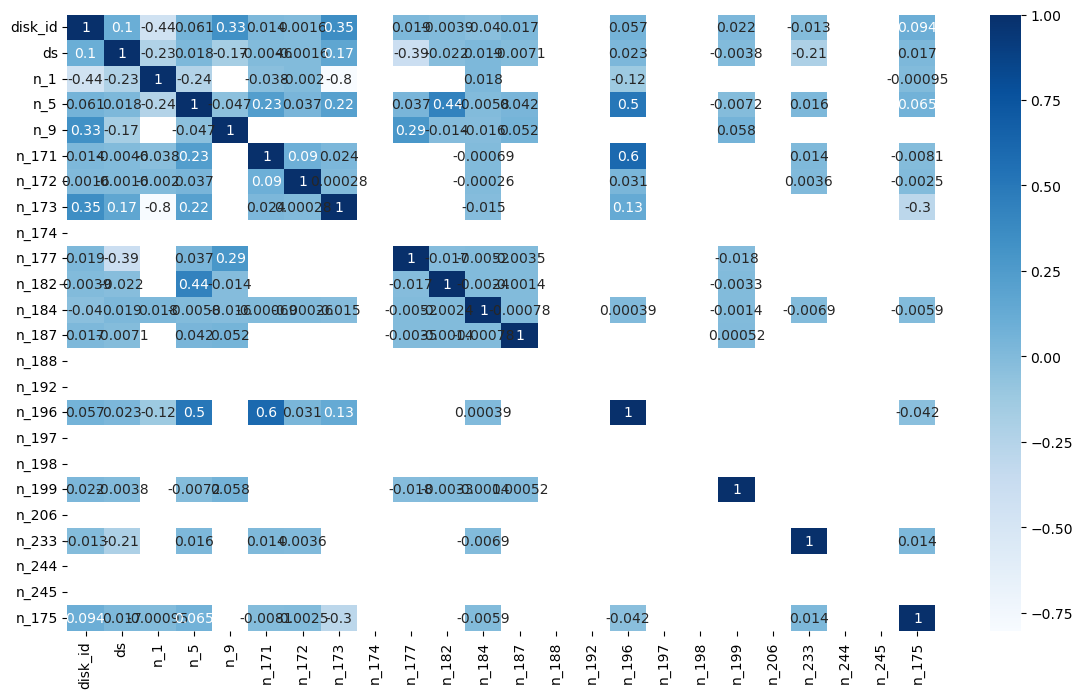

In [38]:
numeric_columns = merged_df.select_dtypes(include='number')

plt.figure(figsize=(14, 8))
sns.heatmap(numeric_columns.corr(), annot=True, cmap='Blues')
plt.show()

In [39]:
merged_df

,disk_id,ds,model,n_1,n_5,n_9,n_171,n_172,n_173,n_174,...,n_192,n_196,n_197,n_198,n_199,n_206,n_233,n_244,n_245,n_175
360776,155479,20191125,MC1,100.0,100.0,100.0,100.0,100.0,100.0,100.0,...,NaN,100.0,100.0,100.0,100.0,100.0,NaN,NaN,NaN,NaN
581925,127723,20191125,MC1,100.0,100.0,100.0,100.0,100.0,98.0,100.0,...,NaN,100.0,100.0,100.0,100.0,100.0,NaN,NaN,NaN,NaN
416745,63791,20191125,MC1,100.0,100.0,100.0,100.0,100.0,89.0,100.0,...,NaN,100.0,100.0,100.0,100.0,100.0,NaN,NaN,NaN,NaN
328177,132502,20191125,MC1,100.0,83.0,100.0,100.0,100.0,100.0,100.0,...,NaN,100.0,100.0,100.0,100.0,100.0,NaN,NaN,NaN,NaN
206674,97304,20180218,MC1,100.0,100.0,100.0,100.0,100.0,100.0,100.0,...,NaN,100.0,100.0,100.0,100.0,100.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4915,66066,20190530,MC1,100.0,100.0,100.0,100.0,100.0,98.0,100.0,...,NaN,100.0,100.0,100.0,100.0,100.0,NaN,NaN,NaN,NaN
670,18486,20180524,MB1,NaN,99.0,98.0,NaN,NaN,NaN,NaN,...,NaN,NaN,100.0,NaN,100.0,NaN,NaN,100.0,100.0,NaN
4061,12583,20190221,MB1,NaN,99.0,97.0,NaN,NaN,NaN,NaN,...,NaN,NaN,100.0,NaN,100.0,NaN,NaN,100.0,100.0,NaN
4527,164351,20190519,MC1,100.0,100.0,100.0,100.0,100.0,100.0,100.0,...,NaN,100.0,100.0,100.0,100.0,100.0,NaN,NaN,NaN,NaN


In [40]:
# norm_columns = ['disk_id', 'ds', 'model', 'n_1', 'n_5',  'n_9' , 'n_12', 'n_170',
#                 'n_171', 'n_172','n_173', 'n_174', 'n_180', 'n_183',
#                 'n_184',  'n_187',  'n_188',  'n_190', 'n_194', 
#                 'n_195', 'n_196', 'n_197',  'n_198',  'n_199', ] 
# norm_columns = ['disk_id', 'ds', 'model',  'n_5', 'n_187',  'n_188', 'n_197',  'n_198' ] 


# Create a new DataFrame from the subset of columns
# norm_df = merged_df[norm_columns]
norm_df = merged_df

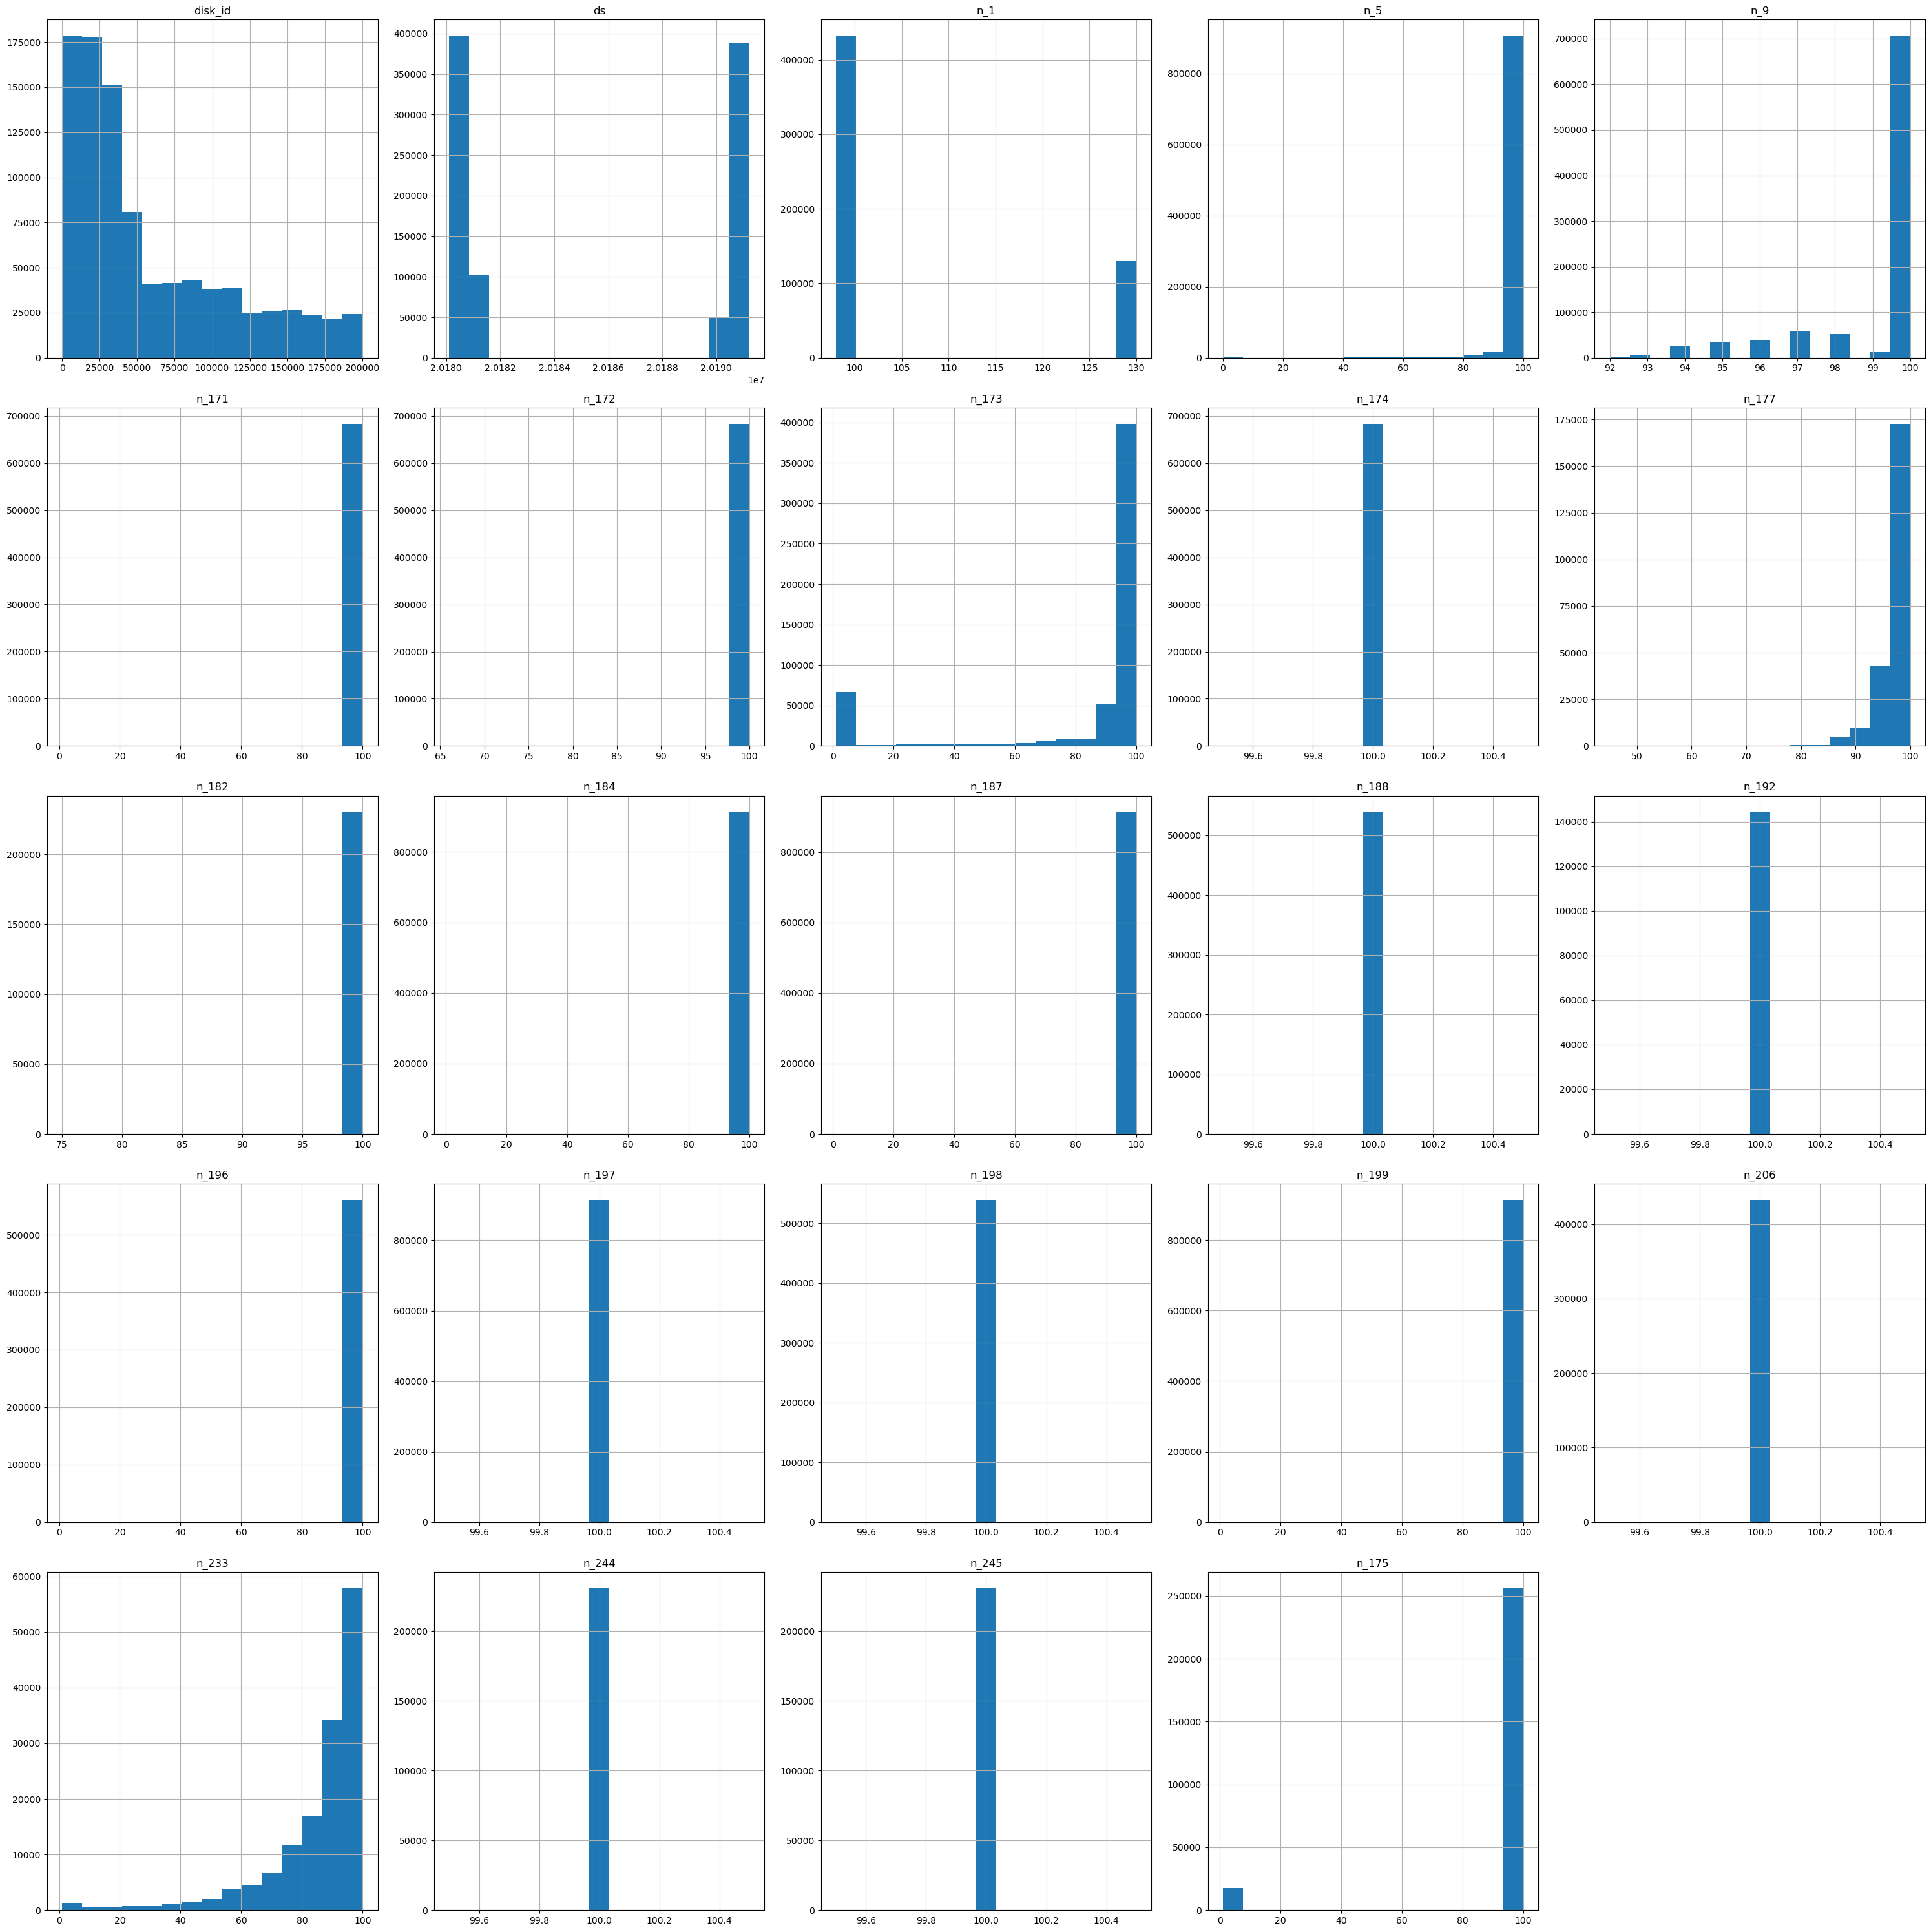

In [41]:
norm_df.hist(bins=15,figsize=(30,30),grid=True)
plt.tight_layout()
plt.show()

In [42]:
# norm_df[columns_to_impute]
# norm_df[columns_to_impute]

In [43]:
# columns_to_impute = ['n_1', 'n_5',  'n_9' , 'n_12', 'n_170',
#                 'n_171', 'n_172','n_173', 'n_174', 'n_180', 'n_183',
#                 'n_184',  'n_187',  'n_188',  'n_190', 'n_194', 
#                 'n_195', 'n_196', 'n_197',  'n_198',  'n_199'] 
columns_to_impute = get_columns_except(norm_df, ['disk_id', 'ds', 'model'  ] )


# Create a pipeline for imputation
# imputer = ColumnTransformer(transformers=[('impute', SimpleImputer(strategy='most_frequent'), columns_to_impute)])

# Fit and transform the pipeline on the DataFrame
df_filled = fillna_with_mode(norm_df)
df_filled = standardize_subset_columns(df_filled, columns_to_impute)

In [44]:
duplicates = df_filled.duplicated()

# Count the number of duplicates
num_duplicates = duplicates.sum()

In [45]:
df_filled = df_filled[columns_to_impute]

In [46]:
df_filled = select_top_n_features_with_random_forest(df_filled, target_df.values.ravel(), n=8, random_state=42)
columns_to_impute = df_filled.columns

In [47]:
columns_to_impute

Index(['n_5', 'n_173', 'n_233', 'n_9', 'n_175', 'n_177', 'n_1', 'n_184'], dtype='object')

In [48]:
num_duplicates

464125

In [49]:
# prepro_df = norm_df[['disk_id', 'ds', 'model']].join(df_filled)

In [50]:
logreg_no_reg = LogisticRegression(penalty='l1', solver='liblinear', random_state=42,verbose=10)
param_grid = {
    'C': [0.001, 0.01],
}

# Grid search for each classifier
grid_search_no_reg = GridSearchCV(logreg_no_reg, param_grid, cv=2, scoring='f1',verbose=10)
start_time = time.time()
logreg_no_reg.fit(df_filled, target_df.values.ravel())
end_time = time.time()
training_time = end_time - start_time

print(f'Training Time: {training_time:.2f} seconds')

[LibLinear]Training Time: 3.70 seconds


In [51]:
valid_test = X_test[X_test['target'] == 0]
failed_test = X_test[X_test['target'] == 1]

In [52]:
print("valid hdds:",len(valid_test))
print("failing hdds:",len(failed_test))

valid hdds: 200885
failing hdds: 1900


In [53]:
failed_up_test = resample(failed_test,replace=True,n_samples=len(valid_test),random_state=27)

In [54]:
df_test = pd.concat([valid_test,failed_up_test])
df_test.target.value_counts()

0    200885
1    200885
Name: target, dtype: int64

In [55]:
target_df_test = df_test[['target']]
del df_test['target']

In [56]:
target_df_test

,target
438399,0
433237,0
184176,0
554880,0
139080,0
...,...
3739,1
2724,1
4442,1
3628,1


In [57]:
# norm_df_test = df_test[norm_columns]
norm_df_test = df_test

In [58]:
norm_df_test

,disk_id,ds,model,n_1,n_5,n_9,n_171,n_172,n_173,n_174,...,n_192,n_196,n_197,n_198,n_199,n_206,n_233,n_244,n_245,n_175
438399,142088,20191125,MC1,100.0,100.0,100.0,100.0,100.0,100.0,100.0,...,NaN,100.0,100.0,100.0,100.0,100.0,NaN,NaN,NaN,NaN
433237,73563,20191125,MA2,NaN,100.0,100.0,100.0,100.0,NaN,100.0,...,100.0,NaN,100.0,NaN,100.0,NaN,82.0,NaN,NaN,100.0
184176,30434,20180218,MC1,100.0,100.0,100.0,100.0,100.0,100.0,100.0,...,NaN,100.0,100.0,100.0,100.0,100.0,NaN,NaN,NaN,NaN
554880,26181,20191125,MB2,NaN,100.0,96.0,NaN,NaN,NaN,NaN,...,NaN,NaN,100.0,NaN,100.0,NaN,NaN,100.0,100.0,NaN
139080,24232,20180218,MA1,130.0,93.0,100.0,100.0,100.0,46.0,100.0,...,NaN,100.0,100.0,100.0,100.0,NaN,NaN,NaN,NaN,100.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3739,122561,20181229,MC1,100.0,100.0,100.0,100.0,100.0,100.0,100.0,...,NaN,100.0,100.0,100.0,100.0,100.0,NaN,NaN,NaN,NaN
2724,22387,20181002,MC2,100.0,100.0,100.0,100.0,100.0,99.0,100.0,...,NaN,100.0,100.0,100.0,100.0,100.0,NaN,NaN,NaN,NaN
4442,3690,20190507,MB1,NaN,99.0,96.0,NaN,NaN,NaN,NaN,...,NaN,NaN,100.0,NaN,100.0,NaN,NaN,100.0,100.0,NaN
3628,3219,20181206,MA2,NaN,100.0,100.0,100.0,100.0,NaN,100.0,...,100.0,NaN,100.0,NaN,100.0,NaN,83.0,NaN,NaN,1.0


In [59]:
df_filled_test = fillna_with_mode(norm_df_test)
df_filled_test = standardize_subset_columns(df_filled_test, columns_to_impute)

In [60]:
df_filled_test = df_filled_test[columns_to_impute]

In [61]:
df_filled_test

,n_5,n_173,n_233,n_9,n_175,n_177,n_1,n_184
438399,0.234685,0.360342,0.219048,0.513931,0.135884,0.26142,-0.389587,0.03547
433237,0.234685,0.360342,-1.611696,0.513931,0.135884,0.26142,-0.389587,0.03547
184176,0.234685,0.360342,0.219048,0.513931,0.135884,0.26142,-0.389587,0.03547
554880,0.234685,0.360342,0.219048,-1.799828,0.135884,0.26142,-0.389587,0.03547
139080,-1.382873,-1.731577,0.219048,0.513931,0.135884,0.26142,2.564824,0.03547
...,...,...,...,...,...,...,...,...
3739,0.234685,0.360342,0.219048,0.513931,0.135884,0.26142,-0.389587,0.03547
2724,0.234685,0.321603,0.219048,0.513931,0.135884,0.26142,-0.389587,0.03547
4442,0.003606,0.360342,0.219048,-1.799828,0.135884,0.26142,-0.389587,0.03547
3628,0.234685,0.360342,-1.489647,0.513931,-7.359204,0.26142,-0.389587,0.03547


In [62]:
scorers = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score),
    'recall': make_scorer(recall_score),
    'f1_score': make_scorer(f1_score),
    'roc_auc': make_scorer(roc_auc_score)
}


In [63]:
y_pred_no_reg = logreg_no_reg.predict(df_filled_test)
accuracy_no_reg = accuracy_score(target_df_test, y_pred_no_reg)
precision_no_reg = precision_score(target_df_test, y_pred_no_reg)
recall_no_reg = recall_score(target_df_test, y_pred_no_reg)
f1_no_reg = f1_score(target_df_test, y_pred_no_reg)
print('No regularization - Accuracy: {:.2f}, Precision: {:.2f}, Recall: {:.2f}, F1: {:.2f}'.format(accuracy_no_reg, precision_no_reg, recall_no_reg, f1_no_reg))
print(confusion_matrix(target_df_test, y_pred_no_reg))


No regularization - Accuracy: 0.61, Precision: 0.68, Recall: 0.42, F1: 0.52
[[161613  39272]
 [117075  83810]]


In [64]:
rfc = RandomForestClassifier(verbose=10) 
start_time = time.time()
rfc.fit(df_filled, target_df.values.ravel()) 
end_time = time.time()
training_time = end_time - start_time

print(f'Training Time: {training_time:.2f} seconds')
# predictions (notice the small 'p' to differentiate from model 1) 
ypred = rfc.predict(df_filled_test) 

building tree 1 of 100


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s remaining:    0.0s


building tree 2 of 100


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.3s remaining:    0.0s


building tree 3 of 100


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    2.0s remaining:    0.0s


building tree 4 of 100


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    2.5s remaining:    0.0s


building tree 5 of 100


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    3.1s remaining:    0.0s


building tree 6 of 100


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    3.8s remaining:    0.0s


building tree 7 of 100


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    4.4s remaining:    0.0s


building tree 8 of 100


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    5.0s remaining:    0.0s


building tree 9 of 100


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    5.6s remaining:    0.0s


building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  1.1min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s


Training Time: 65.13 seconds


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    4.8s finished


In [65]:

print("Model used is : Random Forest classifier") 
  
acc = accuracy_score(target_df_test, ypred) 
print("The accuracy is {}".format(acc)) 
  
prec = precision_score(target_df_test, ypred) 
print("The precision is {}".format(prec)) 
  
rec = recall_score(target_df_test, ypred) 
print("The recall is {}".format(rec)) 
  
f1 = f1_score(target_df_test, ypred) 
print("The F1-Score is {}".format(f1)) 
  
# MCC = matthews_corrcoef(target_df_test, ypred) 
# print("The Matthews correlation coefficient is{}".format(MCC)) 

Model used is : Random Forest classifier
The accuracy is 0.783035069816064
The precision is 0.7450025638926354
The recall is 0.8606516165965602
The F1-Score is 0.798662213537697


In [66]:
importances = rfc.feature_importances_
importances

array([0.32823205, 0.22747018, 0.19398883, 0.12617086, 0.05025954,
       0.03419391, 0.02900239, 0.01068224])

In [67]:
sorted_indices = importances.argsort()[::-1]
sorted_indices

array([0, 1, 2, 3, 4, 5, 6, 7], dtype=int64)

In [68]:
for i in sorted_indices:
    print(f"Feature: {df_filled.columns[i]}, Importance: {importances[i]}")

Feature: n_5, Importance: 0.32823204502950876
Feature: n_173, Importance: 0.2274701775232386
Feature: n_233, Importance: 0.19398882911526802
Feature: n_9, Importance: 0.12617086275095815
Feature: n_175, Importance: 0.05025954469826445
Feature: n_177, Importance: 0.034193909397960735
Feature: n_1, Importance: 0.02900239435313549
Feature: n_184, Importance: 0.01068223713166566


In [69]:
naive_bayes_classifier = GaussianNB()

# Train the classifier on the training data

start_time = time.time()
naive_bayes_classifier.fit(df_filled, target_df.values.ravel())
end_time = time.time()
training_time = end_time - start_time

print(f'Training Time: {training_time:.2f} seconds')

# Make predictions on the testing set
y_pred = naive_bayes_classifier.predict(df_filled_test)

# Calculate and print accuracy, precision, recall, F1 score, and confusion matrix
accuracy = accuracy_score(target_df_test, y_pred)
precision = precision_score(target_df_test, y_pred)
recall = recall_score(target_df_test, y_pred)
f1 = f1_score(target_df_test, y_pred)
conf_matrix = confusion_matrix(target_df_test, y_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

print("Confusion Matrix:")
print(conf_matrix)

Training Time: 0.22 seconds
Accuracy: 0.6047863205316475
Precision: 0.8353512824597737
Recall: 0.26101998655947434
F1 Score: 0.39775464148224
Confusion Matrix:
[[190550  10335]
 [148450  52435]]


In [70]:
# Create the XGBoost classifier
xgb_classifier = xgb.XGBClassifier()

start_time = time.time()
# Train the classifier on the training data
xgb_classifier.fit(df_filled, target_df.values.ravel())
end_time = time.time()
training_time = end_time - start_time

print(f'Training Time: {training_time:.2f} seconds')


Training Time: 28.14 seconds


In [71]:
# Make predictions on the test data
y_pred = xgb_classifier.predict(df_filled_test)

In [72]:
# Calculate accuracy
accuracy = accuracy_score(target_df_test, y_pred)
precision = precision_score(target_df_test, y_pred)
recall = recall_score(target_df_test, y_pred)
f1 = f1_score(target_df_test, y_pred)
conf_matrix = confusion_matrix(target_df_test, y_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

# Generate a classification report
report = classification_report(target_df_test, y_pred)
print("Classification Report:")
print(report)

Accuracy: 0.7938895387908504
Precision: 0.7500889574190488
Recall: 0.8814595415287353
F1 Score: 0.8104853382400397
Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.71      0.77    200885
           1       0.75      0.88      0.81    200885

    accuracy                           0.79    401770
   macro avg       0.80      0.79      0.79    401770
weighted avg       0.80      0.79      0.79    401770



In [73]:


train_data = lgb.Dataset(df_filled, label=target_df)

# Set hyperparameters for the LightGBM model
params = {
    'objective': 'binary',
    'metric': 'binary_logloss',
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9
}

# Train the LightGBM model
num_rounds = 100


start_time = time.time()
model = lgb.train(params, train_data, num_rounds)
end_time = time.time()
training_time = end_time - start_time

print(f'Training Time: {training_time:.2f} seconds')

# Make predictions on the test data
y_pred_probs = model.predict(df_filled_test)
y_pred = [1 if prob >= 0.5 else 0 for prob in y_pred_probs]

# Evaluate the model's performance
accuracy = accuracy_score(target_df_test, y_pred)
precision = precision_score(target_df_test, y_pred)
recall = recall_score(target_df_test, y_pred)
f1 = f1_score(target_df_test, y_pred)
conf_matrix = confusion_matrix(target_df_test, y_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

report = classification_report(target_df_test, y_pred)
print("Classification Report:")
print(report)

[LightGBM] [Info] Number of positive: 468644, number of negative: 468644
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.034245 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 142
[LightGBM] [Info] Number of data points in the train set: 937288, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Training Time: 5.50 seconds
Accuracy: 0.7753814371406527
Precision: 0.7226891771127696
Recall: 0.893690419891978
F1 Score: 0.7991444526299623
Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.66      0.75    200885
           1       0.72      0.89      0.80    200885

    accuracy                           0.78    401770
   macro avg       0.79      0.78      0.77    401770
weighted avg       0.79      0.78      0.77    401770



In [78]:
# Create a simple neural network model
model = Sequential()
model.add(Dense(16, input_shape=(df_filled.shape[1],), activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
learning_rate = 0.001


model.compile(optimizer=Adam(learning_rate=learning_rate),
              loss=BinaryCrossentropy(),
              metrics=[Accuracy(), Recall(), Precision()])





# Train the model
epochs = 5
batch_size = 32
start_time = time.time()
model.fit(df_filled, target_df, epochs=epochs, batch_size=batch_size, verbose=1)
end_time = time.time()
training_time = end_time - start_time
print(f'Training Time: {training_time:.2f} seconds')


Epoch 1/5
29291/29291 [==============================] - 41s 1ms/step - loss: 0.4246 - accuracy: 3.8195e-04 - recall_1: 0.8264 - precision_1: 0.7528
Epoch 2/5
29291/29291 [==============================] - 40s 1ms/step - loss: 0.4053 - accuracy: 9.6022e-06 - recall_1: 0.8764 - precision_1: 0.7463
Epoch 3/5
29291/29291 [==============================] - 42s 1ms/step - loss: 0.4032 - accuracy: 0.0000e+00 - recall_1: 0.8785 - precision_1: 0.7460
Epoch 4/5
29291/29291 [==============================] - 42s 1ms/step - loss: 0.4020 - accuracy: 0.0000e+00 - recall_1: 0.8793 - precision_1: 0.7462
Epoch 5/5
29291/29291 [==============================] - 45s 2ms/step - loss: 0.4012 - accuracy: 0.0000e+00 - recall_1: 0.8780 - precision_1: 0.7467
Training Time: 209.97 seconds


In [79]:
# Evaluate the model on the testing set
loss, accuracy, recall, precision = model.evaluate(df_filled_test, target_df_test, verbose=10)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)
print("Test Recall:", recall)
print("Test Precision:", precision)

# Calculate the F1 score
f1_score = 2 * (precision * recall) / (precision + recall)
print("Test F1 Score:", f1_score)

Test Loss: 0.4035363793373108
Test Accuracy: 0.0
Test Recall: 0.8543395400047302
Test Precision: 0.7596234083175659
Test F1 Score: 0.8042022450558252


In [76]:
# # Create an SVM classifier with a linear kernel
# svm_classifier = SVC(kernel='linear')

# # Fit the classifier to the training data
# svm_classifier.fit(df_filled, target_df.values.ravel())

In [77]:
# # Make predictions on the testing set
# y_pred = svm_classifier.predict(df_filled_test)

# # Calculate accuracy and print the classification report and confusion matrix
# accuracy = accuracy_score(target_df_test, y_pred)
# print("Accuracy:", accuracy)

# print("Classification Report:")
# print(classification_report(target_df_test, y_pred))

# print("Confusion Matrix:")
# print(confusion_matrix(target_df_test, y_pred))